# Machine Learning - Reseller Classification

## Project Scope:

The purpose of this project is to distinguish the resellers from the customers who purchased on the US website. Resellers harm the brand reputation, product market price, and inventory management of the company. Therefore, the company wants to identify and block the resellers' shipments.

The project involves a binary classification problem that may require feature engineering if necessary. The data source is a structured dataset in the database, which includes numerical and categorical features.

This notebook showcases three distinct Keras models, each employing different design architectures. The initial model leverages a series of dense layers, while the second model incorporates multiple GRU layers. Lastly, the third model implements a transformer encoder.  

## Dataset column descriptions:

      'sales\_channel\_id': US sales channel id is 1, integer 

      'external\_customer\_id': customer id, integer 

      'email': customer email address, string

      'last\_shipping\_address\_address1': the shipping address 1 used in the last transaction, string

      'last\_shipping\_address\_address2': the shipping address 2 used in the last transaction, string

      'last\_shipping\_address\_city': the shipping city used in the last transaction, string

      'last\_shipping\_address\_zip': the shipping address zip code used in the last transaction, string

      'last\_shipping\_address\_country\_code': the shipping country code used in the last transaction, string

      'total\_orders': the total count of orders purchased by the customer, integer 

      'total\_units': the total count of item units purchased by the customer, integer 

      'total\_gross': the total gross sales spent by the customer, float

      'total\_discounts': the total discounts used by the customer, float

      'total\_returns': the total returns to the customer, float

      'total\_shipping': the total shipping spent by the customer, float

      'total\_taxes': the total taxes purchased by the customer, float

      'r\_score': recency score represents how recently a customer has made a purchase, score 1-5, integer 

      'f\_score': frequency score represents how often a customer makes a purchase, score 1-5, integer 

      'm\_score': monetary value score represents how much money a customer spends on purchases, score 1-5, integer

      'rfm\_score': r\_score + f\_score + m\_score, integer 

      'is\_reseller': 1 (reseller) or 0 (normal customer), this is the target, integer

## Preliminary Analysis:

The main features that are considered for the analysis are:

\- Total orders, units, gross sales, and discounts: These features reflect the reseller behavior of buying large quantities of products during the discount season.

\- Total returns: This feature indicates the reseller tendency of returning unsold products.

\- Total shipping and taxes: These features provide some information about the reseller location.

\- R\_score, F\_score, M\_score, RFM\_score: These features are derived from the recency, frequency, and monetary value of each customer's purchases and may help in training a model. The training process utilizes only R\_score, F\_score, and RFM\_score as the input features. This is based on the rationale that these three features encompass the information of M\_score. Including M\_score as an additional feature would result in a correlation problem.

One challenge in the reseller classification problem is to distinguish between loyal customers and resellers. Loyal customers spend a lot of money in total, but each transaction does not include many units. Resellers purchase multiple units in a single transaction. Therefore, two custom features are created to capture this difference:

\- Average units per order: This feature is obtained by dividing total units by total orders.

\- Average gross sales per order: This feature is obtained by dividing total gross sales by total orders.

The resellers may follow a different pattern in these two custom features compared to the loyal customers.

The preliminary training stage involves training a model with all the numerical features plus the two custom features. 

## Improvements 1:

Based on the feedback from the team who identified the resellers, I have analyzed the following criteria: email address, shipping address, and IP address. I have discovered that some resellers use multiple email accounts and vary their shipping addresses to avoid detection. However, these methods can be exposed by examining the email domain name and the embedding shipping address of the orders. The IP address is not a reliable indicator, as it can be easily changed by using a VPN. Therefore, I propose to create a model that considers both numerical and categorical features (excludes IP address) of the orders, and uses an embedding space to measure the distance between different shipping addresses. This will help us to detect the resellers' intentions more accurately.

## Improvements 2:

The observation reveals that resellers exhibit a tendency to procure a substantial number of units for each Stock Keeping Unit (SKU) and strive to acquire a wide variety of SKUs. This is primarily driven by their need for product diversity and the requirement to maintain ample stock levels in their warehouses. Resellers often divide their orders into smaller batches, resulting in a higher total unit count and distinct SKU count compared to regular customers. The latter group typically possesses personal preferences that dictate their selection of SKUs based on their individual style. In contrast, resellers lack such preferences as their objective is to cater to the diverse needs of various customers. Consequently, the implementation of two custom features can aid in identifying resellers. The first custom feature involves calculating the average distinct SKU count per order, which counts the number of unique SKUs across a customer's order history and dividing it by the total number of orders. The second custom feature, units per SKU, is computed by dividing the units per order by the average distinct SKU count per order. By incorporating these two custom features into the model training process, reseller classification can be significantly improved.

## Define input and output

In [ ]:
model_name = "Reseller Classifier"
input_table_name = "customer"
output_table_name = "ml_resellers"

In [ ]:

import os

# Define Azure SQL Database connection
jdbcHostname = os.getenv("SQLDB_HOST")
user = os.getenv("SQLDB_USER")
password = os.getenv("SQLDB_PW")
jdbcDatabase = os.getenv("SQLDB_DB")
jdbcPort = 1433
jdbcUrl = "jdbc:sqlserver://{0}:{1};database={2}".format(jdbcHostname, jdbcPort, jdbcDatabase)
connectionProperties = {
"user" : user,
"password" : password,
"driver" : "com.microsoft.sqlserver.jdbc.SQLServerDriver"
}

In [ ]:
# Load table as a Spark DataFrame
customers = (spark.read
  .format("jdbc")
  .option("url", jdbcUrl)
  .option("dbtable", input_table_name)
  .option("user", user)
  .option("password", password)
  .load()
)

# Take US data
customers = customers.where('sales_channel_id = 1')

In [ ]:
input_columns = ['sales_channel_id'
      ,'external_customer_id'
      ,'customer_type'
      ,'email'
      ,'first_name'
      ,'last_name'
      ,'last_shipping_address_address1'
      ,'last_shipping_address_address2'
      ,'last_shipping_address_city'
      ,'last_shipping_address_country'
      ,'last_shipping_address_phone'
      ,'last_shipping_address_province'
      ,'last_shipping_address_zip'
      ,'last_shipping_address_country_code'
      ,'last_shipping_address_province_code'
      ,'first_transaction_date'
      ,'first_transaction_id'
      ,'last_transaction_date'
      ,'last_transaction_id'
      ,'last_transaction_ip'
      ,'total_orders'
      ,'total_units'
      ,'total_gross'
      ,'total_discounts'
      ,'total_returns'
      ,'total_shipping'
      ,'total_taxes'
      ,'r_score'
      ,'f_score'
      ,'m_score'
      ,'rfm_score'
      ,'is_reseller'
      ,'avg_sku_count'
      ]

## Create Custom Features

In [ ]:
import pyspark.sql.functions as F

# Create 5 custom features
df = (
    customers.select(
        [customers[col] for col in input_columns]
        + [
            F.substring_index(
                F.substring_index(F.lower(customers["email"]), "@", -1), ".", 1
            ).alias("email_domain")
        ]
        + [
            F.concat(
                F.coalesce(F.lower(customers["last_shipping_address_address1"]), F.lit("")),
                F.lit(" "),
                F.coalesce(F.lower(customers["last_shipping_address_address2"]), F.lit("")),
                F.lit(" "),
                F.coalesce(F.lower(customers["last_shipping_address_city"]), F.lit("")),
                F.lit(" "),
                F.coalesce(F.lower(customers["last_shipping_address_country_code"]), F.lit("")),
                F.lit(" "),
                F.coalesce(F.lower(customers["last_shipping_address_zip"]), F.lit("")),
            ).alias("address")
        ]
    )
    .withColumn("units_per_order", F.col("total_units") * 1.0 / F.col("total_orders"))
    .withColumn("gross_per_order", F.col("total_gross") * 1.0 / F.col("total_orders"))
    .withColumn("units_per_sku", F.col('units_per_order') * 1.0 / F.col('avg_sku_count'))
)

## Data Cleansing

In [ ]:
IDENTIFIERS = ['external_customer_id', 'email']
CONTINUOUS_COLUMNS = [
  'total_orders',
  'total_units',
  'total_gross',
  'total_discounts',
  'total_returns',
  'total_shipping',
  'total_taxes',
  'r_score',
  'f_score',
  'rfm_score',
  'avg_sku_count',
  'units_per_order', 
  'gross_per_order', 
  'units_per_sku'
]
CATEGORICAL_COLUMNS = ['email_domain', 'address']
TARGET_COLUMN = 'is_reseller'

In [ ]:
# Drop nulls
customers = df.dropna(
  how='any',
  subset=[x for x in IDENTIFIERS + CONTINUOUS_COLUMNS + [TARGET_COLUMN] + CATEGORICAL_COLUMNS]
)

# Remove duplicates
customers = customers.dropDuplicates(subset=['sales_channel_id', 'external_customer_id']) 

## Train Test Split

In [ ]:
# Take all the US resellers
resellers = customers.where('sales_channel_id = 1 and is_reseller = 1 and CAST(last_transaction_date AS DATE) <= "2023-05-28"')
# Take US normal customers in 2023 only
normal_customers = customers.where('sales_channel_id = 1 and is_reseller = 0 and CAST(last_transaction_date AS DATE) between "2023-01-01" and "2023-05-28" ')

# Split the resellers and normal customers, then merge them together, and then suffle the order. 
# This ensures train, test, val dataset have equal portion of resellers and normal customers.
train_resellers, test_resellers, val_resellers = resellers.randomSplit([0.8, 0.1, 0.1], seed=42)
train_normal, test_normal, val_normal = normal_customers.randomSplit([0.8, 0.1, 0.1], seed=42)

train = train_resellers.union(train_normal).orderBy(F.rand(seed=42))
test = test_resellers.union(test_normal).orderBy(F.rand(seed=42))
val = val_resellers.union(val_normal).orderBy(F.rand(seed=42))

In [ ]:
import numpy as np

# Convert the PySpark DataFrames to Pandas DataFrames
train_df = train.toPandas()
test_df = test.toPandas()
val_df = val.toPandas()

# Split the data into features (X) and target (y)
# Convert continuous features to float32 and categorical features to string
y_train = train_df[[TARGET_COLUMN]].values.astype(np.float32)
y_test = test_df[[TARGET_COLUMN]].values.astype(np.float32)
y_val = val_df[[TARGET_COLUMN]].values.astype(np.float32)

X_con_train = train_df[CONTINUOUS_COLUMNS].astype(np.float32)
X_cat_email_train = train_df[CATEGORICAL_COLUMNS].astype(str).values[:, 0]
X_cat_address_train = train_df[CATEGORICAL_COLUMNS].astype(str).values[:, 1]

X_con_test = test_df[CONTINUOUS_COLUMNS].astype(np.float32)
X_cat_email_test = test_df[CATEGORICAL_COLUMNS].astype(str).values[:, 0]
X_cat_address_test = test_df[CATEGORICAL_COLUMNS].astype(str).values[:, 1]

X_con_val = val_df[CONTINUOUS_COLUMNS].astype(np.float32)
X_cat_email_val = val_df[CATEGORICAL_COLUMNS].astype(str).values[:, 0]
X_cat_address_val = val_df[CATEGORICAL_COLUMNS].astype(str).values[:, 1]

/databricks/spark/python/pyspark/sql/pandas/utils.py:105: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [total_gross, total_discounts, total_returns, total_shipping, total_taxes] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.
  warnings.warn(
/databricks/spark/python/pyspark/sql/pandas/utils.py:105: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [total_gross, total_discounts, total_returns, total_shipping, total_taxes] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.
  warnings.warn(
/databricks/spark/python/pyspark/sql/pandas/utils.py:105: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [total_gross, total_discounts, total_returns, total_shipping, total_taxes] If 

In [ ]:
# Take the future data to check the generalization
new_df = customers.where('sales_channel_id = 1 and CAST(last_transaction_date AS DATE) > "2023-05-28"').orderBy(F.rand(seed=42)).toPandas()

y_new = new_df[[TARGET_COLUMN]].values.astype(np.float32)
X_con_new = new_df[CONTINUOUS_COLUMNS].astype(np.float32)
X_cat_email_new = new_df[CATEGORICAL_COLUMNS].astype(str).values[:, 0]
X_cat_address_new = new_df[CATEGORICAL_COLUMNS].astype(str).values[:, 1]

/databricks/spark/python/pyspark/sql/pandas/utils.py:105: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [total_gross, total_discounts, total_returns, total_shipping, total_taxes] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.
  warnings.warn(


# Train the preprocessing layers

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [ ]:
EMAIL_MAX_TOKENS = 5000
EMAIL_MAX_LENGTH = 2

ADDRESS_MAX_TOKENS = 100000
ADDRESS_MAX_LENGTH = 64

# Train a tokenizer for email domain string
email_tokenizer = layers.TextVectorization(
    max_tokens=EMAIL_MAX_TOKENS,
    output_mode='int',
    output_sequence_length=EMAIL_MAX_LENGTH
)
email_tokenizer.adapt(X_cat_email_train)

# Train a tokenizer for address string
address_tokenizer = layers.TextVectorization(
    max_tokens=ADDRESS_MAX_TOKENS,
    output_mode='int',
    output_sequence_length=ADDRESS_MAX_LENGTH
)
address_tokenizer.adapt(X_cat_address_train)

# Train a normalizer for continuos features
normalizer = layers.Normalization()
normalizer.adapt(X_con_train)

#Build a model with Dense (brenchmark)

In [ ]:
keras.backend.clear_session()

EMBED_DIM = 61

inp_cat_email_data = layers.Input(shape=(), dtype=tf.string) # mention dtype is important. otherwise, you will get the error of cast string to float.
inp_cat_address_data = layers.Input(shape=(), dtype=tf.string) # mention dtype is important. otherwise, you will get the error of cast string to float.
inp_num_data = layers.Input(shape=(X_con_train.shape[1], ))

tokenized_email = email_tokenizer(inp_cat_email_data)
tokenized_address = address_tokenizer(inp_cat_address_data)

emb_email = layers.Embedding(input_dim=EMAIL_MAX_TOKENS, 
                             output_dim=EMBED_DIM, 
                             mask_zero=True,
                             )(tokenized_email)
emb_address = layers.Embedding(input_dim=ADDRESS_MAX_TOKENS,
                               output_dim=EMBED_DIM,
                               mask_zero=True,
                               )(tokenized_address)

nor = normalizer(inp_num_data)

flatten_email = layers.Flatten()(emb_email)
flatten_address = layers.Flatten()(emb_address)

conc = layers.Concatenate()([flatten_email, flatten_address, nor])

x = layers.Dense(512, activation='relu')(conc)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dense(8, activation='relu')(x)
x = layers.Dropout(0.5)(x)

out = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs=[inp_cat_email_data, inp_cat_address_data, inp_num_data], outputs=out)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Precision(),
                  tf.keras.metrics.Recall()])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 2)           0           ['input_1[0][0]']                
 ization)                                                                                         
                                                                                                  
 text_vectorization_1 (TextVect  (None, 64)          0           ['input_2[0][0]']            

## Train the model

In [ ]:
import mlflow.keras

mlflow.keras.autolog()

2023/06/04 21:09:01 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


In [ ]:
# Make sure to empty the destination to keep the callbacks' results
dbutils.fs.rm("/model/classification/binary/reseller_classifier/keras/Dense/", recurse=True)

False

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the paths to save the callbacks' results
experiment_log_dir = "/model/classification/binary/reseller_classifier/keras/Dense/tb_transfomer"
checkpoint_path = "/model/classification/binary/reseller_classifier/keras/Dense/keras_checkpoint_weights_transformer.ckpt"

# Create callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=experiment_log_dir)
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor="loss", mode="min", patience=5)

In [ ]:
EPOCHS = 100

history = model.fit(x=[X_cat_email_train, X_cat_address_train, X_con_train], 
                    y=y_train, 
                    epochs=EPOCHS, 
                    validation_data=([X_cat_email_val, X_cat_address_val, X_con_val], y_val),
                    callbacks=[tensorboard_callback, model_checkpoint, early_stopping]
                    )

2023/06/04 21:09:23 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0a639a685ce84e2bb9e80d90cd542d08', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/100
  99/4811 [..............................] - ETA: 8:52 - loss: 0.3812 - accuracy: 0.9220 - precision: 0.0407 - recall: 0.4762

*** WARNING: max output size exceeded, skipping output. ***

4811/4811 [==============================] - ETA: 0s - loss: 0.0529 - accuracy: 0.9963 - precision: 0.6522 - recall: 0.6923
Epoch 1: val_loss improved from inf to 0.02548, saving model to /model/classification/binary/reseller_classifier/keras/Dense/keras_checkpoint_weights_transformer.ckpt


INFO:tensorflow:Assets written to: /model/classification/binary/reseller_classifier/keras/Dense/keras_checkpoint_weights_transformer.ckpt/assets


INFO:tensorflow:Assets written to: /model/classification/binary/reseller_classifier/keras/Dense/keras_checkpoint_weights_transformer.ckpt/assets


4811/4811 [==============================] - 348s 72ms/step - loss: 0.0529 - accuracy: 0.9963 - precision: 0.6522 - recall: 0.6923 - val_loss: 0.0255 - val_accuracy: 0.9967 - val_precision: 1.0000 - val_recall: 0.2955
Epoch 2/100
  97/4811 [..............................] - ETA: 5:42 - loss: 0.0104 - accuracy: 0.9997 - pr

*** WARNING: max output size exceeded, skipping output. ***

4811/4811 [==============================] - ETA: 0s - loss: 0.0093 - accuracy: 0.9985 - precision: 0.9414 - recall: 0.7799
Epoch 2: val_loss improved from 0.02548 to 0.00257, saving model to /model/classification/binary/reseller_classifier/keras/Dense/keras_checkpoint_weights_transformer.ckpt


INFO:tensorflow:Assets written to: /model/classification/binary/reseller_classifier/keras/Dense/keras_checkpoint_weights_transformer.ckpt/assets


INFO:tensorflow:Assets written to: /model/classification/binary/reseller_classifier/keras/Dense/keras_checkpoint_weights_transformer.ckpt/assets


4811/4811 [==============================] - 326s 68ms/step - loss: 0.0093 - accuracy: 0.9985 - precision: 0.9414 - recall: 0.7799 - val_loss: 0.0026 - val_accuracy: 0.9993 - val_precision: 0.9512 - val_recall: 0.8864
Epoch 3/100
  98/4811 [..............................] - ETA: 5:10 - loss: 0.0106 - accuracy: 0.9978 - precision: 0.9333 - recall: 0.7000

*** WARNING: max output size exceeded, skipping output. ***

4811/4811 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 0.9995 - precision: 0.9898 - recall: 0.9231
Epoch 17: val_loss did not improve from 0.00257
4811/4811 [==============================] - 333s 69ms/step - loss: 0.0030 - accuracy: 0.9995 - precision: 0.9898 - recall: 0.9231 - val_loss: 0.0108 - val_accuracy: 0.9990 - val_precision: 0.8557 - val_recall: 0.9432


2023/06/04 22:43:41 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: tuple index out of range
2023/06/04 22:43:41 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpesjt025s/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpesjt025s/model/data/model/assets
2023/06/04 22:44:05 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/databricks/python/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


In [ ]:
# Turn off the autolog
mlflow.keras.autolog(disable=True)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir $experiment_log_dir

Your log directory might be ephemeral to the cluster, which will be deleted after cluster termination or restart. You can choose a log directory under `/dbfs/` to persist your logs in DBFS.


Launching TensorBoard...

Open in a new tab
 
 Note: TensorBoard is only available when this notebook remains attached to the cluster. 
 
 
 Note: This cell needs to be re-run for TensorBoard to be available if this notebook is imported into a different workspace.

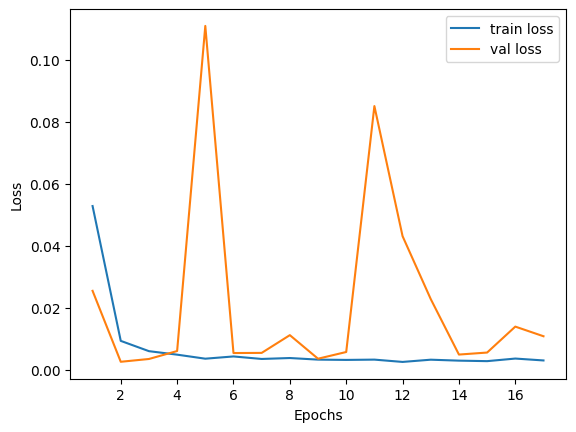

In [ ]:
import matplotlib.pyplot as plt 

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, label='train loss')
plt.plot(epochs, val_loss_values, label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

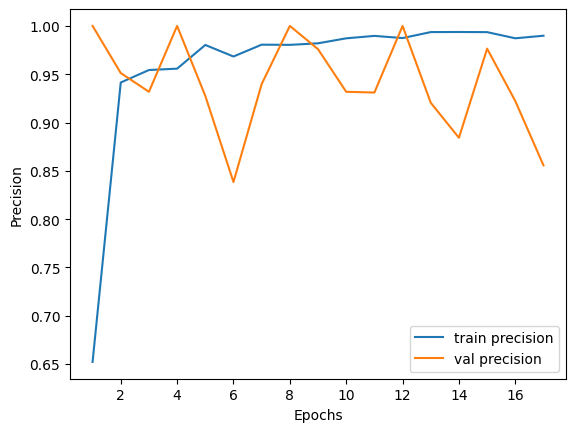

In [ ]:
precision_values = history_dict['precision']
val_precision_values = history_dict['val_precision']
epochs = range(1, len(precision_values) + 1)
plt.plot(epochs, precision_values, label='train precision')
plt.plot(epochs, val_precision_values, label='val precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

## Evaluate the model

In [ ]:
model.evaluate(x=(X_cat_email_val, X_cat_address_val, X_con_val), y=y_val)

594/594 [==============================] - 2s 4ms/step - loss: 0.0108 - accuracy: 0.9990 - precision: 0.8557 - recall: 0.9432


[0.010820056311786175,
 0.9989995956420898,
 0.8556700944900513,
 0.9431818127632141]

In [ ]:
from sklearn.metrics import precision_recall_curve

y_pred = model.predict((X_cat_email_val, X_cat_address_val, X_con_val))
precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred)

594/594 [==============================] - 2s 3ms/step


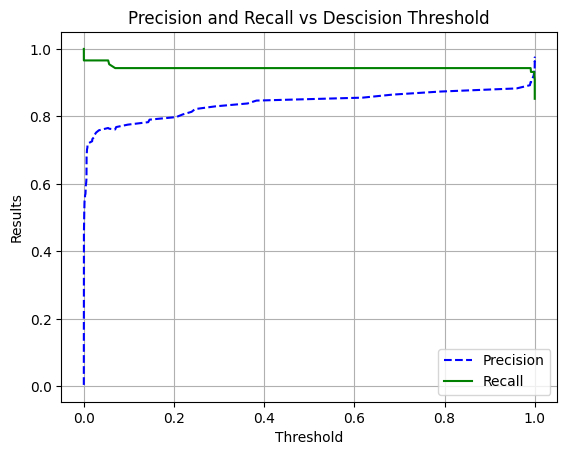

In [ ]:
import matplotlib.pyplot as plt 

plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

plt.xlabel('Threshold')
plt.ylabel('Results')
plt.title('Precision and Recall vs Descision Threshold')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import numpy as np

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

0.9908789

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred_90 = (y_pred >= threshold_90_precision) 
print(precision_score(y_val, y_pred_90), recall_score(y_val, y_pred_90), f1_score(y_val, y_pred_90))

0.9021739130434783 0.9431818181818182 0.9222222222222224


In [ ]:
from sklearn.metrics import precision_recall_curve

y_pred = model.predict((X_cat_email_test, X_cat_address_test, X_con_test))
y_pred_90 = (y_pred >= threshold_90_precision) 
print(precision_score(y_test, y_pred_90), recall_score(y_test, y_pred_90), f1_score(y_test, y_pred_90))

599/599 [==============================] - 2s 4ms/step
0.9333333333333333 0.9256198347107438 0.9294605809128631


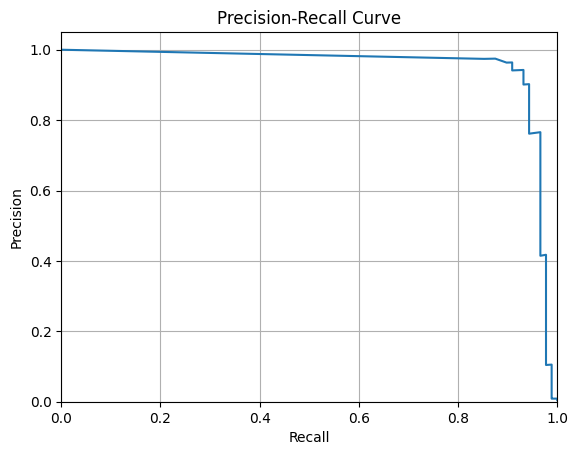

In [ ]:
plt.plot(recalls, precisions)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc_score(y_test, y_pred)

0.9829696321367605

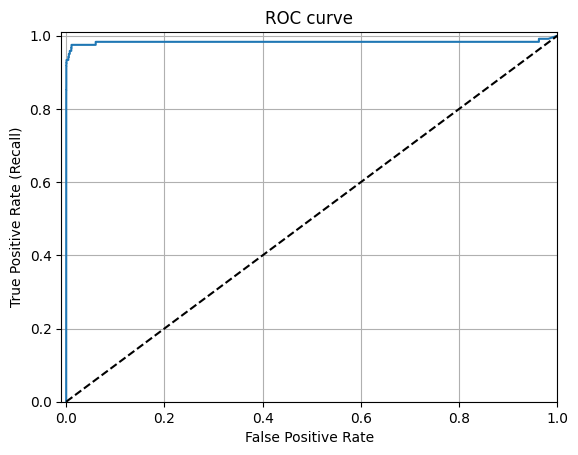

In [ ]:
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.ylim([0, 1.01])
plt.xlim([-0.01, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.title('ROC curve')
plt.show()

## Load the best model

In [ ]:
loaded_model = keras.models.load_model(checkpoint_path)
loaded_model.evaluate(x=(X_cat_email_val, X_cat_address_val, X_con_val), y=y_val)

594/594 [==============================] - 3s 4ms/step - loss: 0.0026 - accuracy: 0.9993 - precision: 0.9512 - recall: 0.8864


[0.002574858022853732,
 0.9992628693580627,
 0.9512194991111755,
 0.8863636255264282]

In [ ]:
loaded_model.evaluate(x=(X_cat_email_test, X_cat_address_test, X_con_test), y=y_test)

599/599 [==============================] - 2s 4ms/step - loss: 0.0079 - accuracy: 0.9990 - precision: 0.9391 - recall: 0.8926


[0.007867286913096905,
 0.998956024646759,
 0.939130425453186,
 0.8925619721412659]

In [ ]:
import mlflow

# Log metrics
metrics = loaded_model.evaluate(x=(X_cat_email_val, X_cat_address_val, X_con_val), y=y_val)

mlflow.log_metric("val_loss", metrics[0])
mlflow.log_metric("val_accuracy", metrics[1])
mlflow.log_metric("val_precision", metrics[2])
mlflow.log_metric("val_recall", metrics[3])

# Log the model
mlflow.tensorflow.log_model(model, "keras_dense_model")

594/594 [==============================] - 2s 4ms/step - loss: 0.0026 - accuracy: 0.9993 - precision: 0.9512 - recall: 0.8864


2023/06/04 22:44:27 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpljmp7l2z/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpljmp7l2z/model/data/model/assets


#Build a model with GRU

In [ ]:
keras.backend.clear_session()

EMBED_DIM = 61
DENSE_DIM = 32

inp_cat_email_data = layers.Input(shape=(), dtype=tf.string) # mention dtype is important. otherwise, you will get the error of cast string to float.
inp_cat_address_data = layers.Input(shape=(), dtype=tf.string) # mention dtype is important. otherwise, you will get the error of cast string to float.
inp_num_data = layers.Input(shape=(X_con_train.shape[1], ))

tokenized_email = email_tokenizer(inp_cat_email_data)
tokenized_address = address_tokenizer(inp_cat_address_data)

emb_email = layers.Embedding(input_dim=EMAIL_MAX_TOKENS, 
                             output_dim=EMBED_DIM, 
                             mask_zero=True,
                             )(tokenized_email)
emb_address = layers.Embedding(input_dim=ADDRESS_MAX_TOKENS,
                               output_dim=EMBED_DIM,
                               mask_zero=True,
                               )(tokenized_address)

nor = normalizer(inp_num_data)

flatten_email = layers.Flatten()(emb_email)
flatten_address = layers.Flatten()(emb_address)

conc = layers.Concatenate()([flatten_email, flatten_address, nor])
reshape = layers.Reshape([40, 101])(conc) #[243, 68]

x = layers.Bidirectional(layers.GRU(DENSE_DIM, return_sequences=True))(reshape)
x = layers.Bidirectional(layers.GRU(DENSE_DIM, return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(DENSE_DIM))(x)
x = layers.Dropout(0.5)(x)

out = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs=[inp_cat_email_data, inp_cat_address_data, inp_num_data], outputs=out)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Precision(),
                  tf.keras.metrics.Recall()])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 2)           0           ['input_1[0][0]']                
 ization)                                                                                         
                                                                                                  
 text_vectorization_1 (TextVect  (None, 64)          0           ['input_2[0][0]']            

## Train the model

In [ ]:
import mlflow.keras

mlflow.keras.autolog()

2023/06/04 04:23:36 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


In [ ]:
# Make sure to empty the destination to keep the callbacks' results
dbutils.fs.rm("/model/classification/binary/reseller_classifier/keras/GRU/", recurse=True)

True

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the paths to save the callbacks' results
experiment_log_dir = "/model/classification/binary/reseller_classifier/keras/GRU/tb_transfomer"
checkpoint_path = "/model/classification/binary/reseller_classifier/keras/GRU/keras_checkpoint_weights_transformer.ckpt"

# Create callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=experiment_log_dir)
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor="loss", mode="min", patience=2)

In [ ]:
EPOCHS = 10

history = model.fit(x=[X_cat_email_train, X_cat_address_train, X_con_train], 
                    y=y_train, 
                    epochs=EPOCHS, 
                    validation_data=([X_cat_email_val, X_cat_address_val, X_con_val], y_val),
                    callbacks=[tensorboard_callback, model_checkpoint, early_stopping]
                    )

2023/06/04 04:23:38 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8bfe812cef194778a9e97a099ece2a11', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
  99/4814 [..............................] - ETA: 11:57 - loss: 0.1000 - accuracy: 0.9883 - precision: 0.0333 - recall: 0.1111

*** WARNING: max output size exceeded, skipping output. ***

4814/4814 [==============================] - ETA: 0s - loss: 0.0070 - accuracy: 0.9985 - precision: 0.8847 - recall: 0.8260
Epoch 1: val_loss improved from inf to 0.00187, saving model to /model/classification/binary/reseller_classifier/keras/GRU/keras_checkpoint_weights_transformer.ckpt


INFO:tensorflow:Assets written to: /model/classification/binary/reseller_classifier/keras/GRU/keras_checkpoint_weights_transformer.ckpt/assets


INFO:tensorflow:Assets written to: /model/classification/binary/reseller_classifier/keras/GRU/keras_checkpoint_weights_transformer.ckpt/assets


4814/4814 [==============================] - 652s 133ms/step - loss: 0.0070 - accuracy: 0.9985 - precision: 0.8847 - recall: 0.8260 - val_loss: 0.0019 - val_accuracy: 0.9992 - val_precision: 0.9294 - val_recall: 0.8977
Epoch 2/10
  97/4814 [..............................] - ETA: 9:58 - loss: 0.0010 - accuracy: 0.9997 - precision: 1.0000 - recall: 0.9565

*** WARNING: max output size exceeded, skipping output. ***

4814/4814 [==============================] - ETA: 0s - loss: 5.0691e-04 - accuracy: 0.9999 - precision: 0.9905 - recall: 0.9834
Epoch 6: val_loss did not improve from 0.00187
4814/4814 [==============================] - 569s 118ms/step - loss: 5.0691e-04 - accuracy: 0.9999 - precision: 0.9905 - recall: 0.9834 - val_loss: 0.0047 - val_accuracy: 0.9989 - val_precision: 0.8681 - val_recall: 0.8977


2023/06/04 05:22:23 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: tuple index out of range
2023/06/04 05:22:23 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpjcvpbs3a/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpjcvpbs3a/model/data/model/assets
2023/06/04 05:23:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/databricks/python/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


In [ ]:
# Turn off the autolog
mlflow.keras.autolog(disable=True)

## Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir $experiment_log_dir

Your log directory might be ephemeral to the cluster, which will be deleted after cluster termination or restart. You can choose a log directory under `/dbfs/` to persist your logs in DBFS.


Launching TensorBoard...

Open in a new tab
 
 Note: TensorBoard is only available when this notebook remains attached to the cluster. 
 
 
 Note: This cell needs to be re-run for TensorBoard to be available if this notebook is imported into a different workspace.

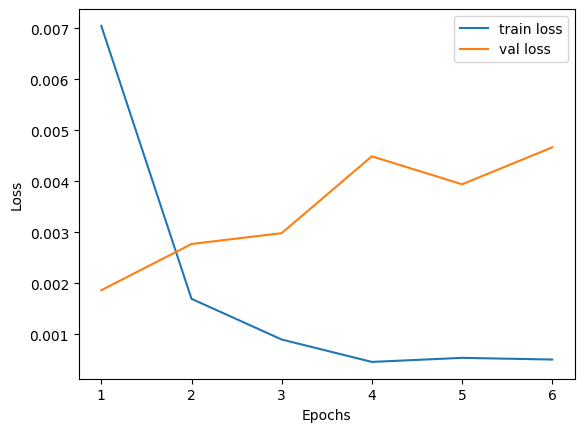

In [ ]:
import matplotlib.pyplot as plt 

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, label='train loss')
plt.plot(epochs, val_loss_values, label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

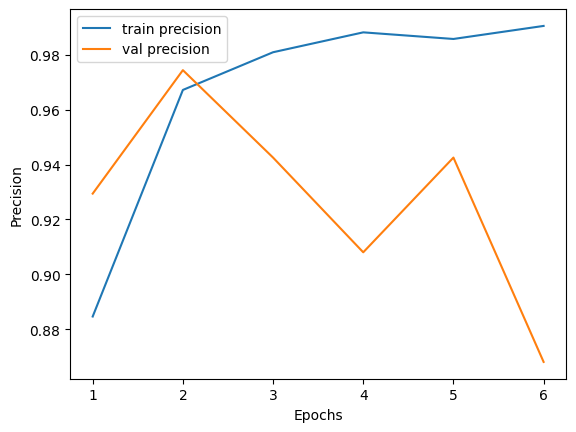

In [ ]:
precision_values = history_dict['precision']
val_precision_values = history_dict['val_precision']
epochs = range(1, len(precision_values) + 1)
plt.plot(epochs, precision_values, label='train precision')
plt.plot(epochs, val_precision_values, label='val precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

## Evaluate the model

In [ ]:
model.evaluate(x=(X_cat_email_val, X_cat_address_val, X_con_val), y=y_val)

595/595 [==============================] - 10s 16ms/step - loss: 0.0047 - accuracy: 0.9989 - precision: 0.8681 - recall: 0.8977


[0.004665900953114033,
 0.9988956451416016,
 0.8681318759918213,
 0.8977272510528564]

In [ ]:
from sklearn.metrics import precision_recall_curve

y_pred = model.predict((X_cat_email_val, X_cat_address_val, X_con_val))
precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred)

595/595 [==============================] - 12s 16ms/step


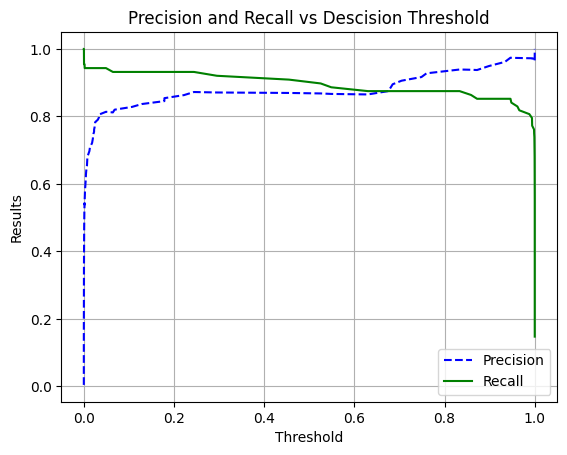

In [ ]:
import matplotlib.pyplot as plt 

plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

plt.xlabel('Threshold')
plt.ylabel('Results')
plt.title('Precision and Recall vs Descision Threshold')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import numpy as np

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

0.7047653

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred_90 = (y_pred >= threshold_90_precision) 
print(precision_score(y_val, y_pred_90), recall_score(y_val, y_pred_90), f1_score(y_val, y_pred_90))

0.9058823529411765 0.875 0.8901734104046243


In [ ]:
from sklearn.metrics import precision_recall_curve

y_pred = model.predict((X_cat_email_test, X_cat_address_test, X_con_test))
y_pred_90 = (y_pred >= threshold_90_precision) 
print(precision_score(y_test, y_pred_90), recall_score(y_test, y_pred_90), f1_score(y_test, y_pred_90))

599/599 [==============================] - 9s 16ms/step
0.8879310344827587 0.8512396694214877 0.869198312236287


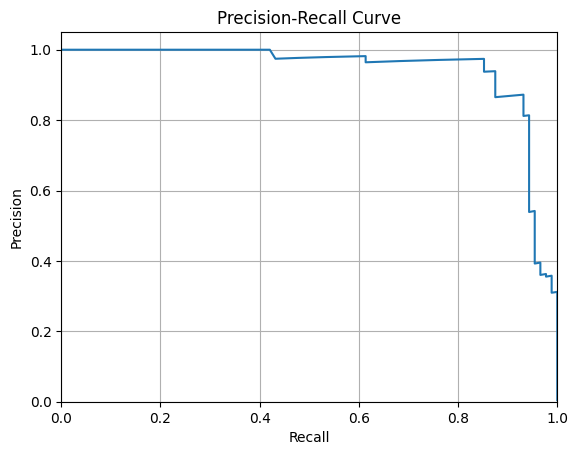

In [ ]:
plt.plot(recalls, precisions)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc_score(y_test, y_pred)

0.9996506751083233

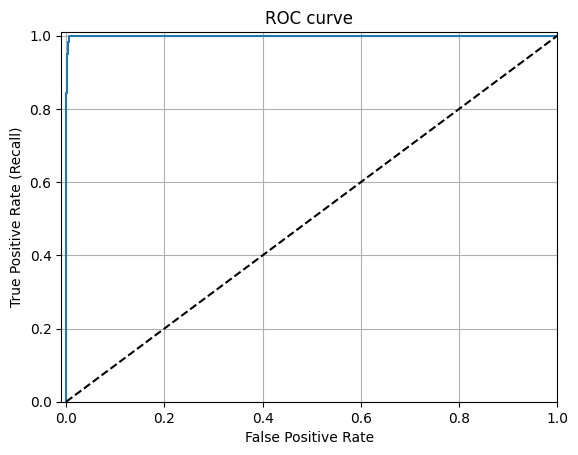

In [ ]:
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.ylim([0, 1.01])
plt.xlim([-0.01, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.title('ROC curve')
plt.show()

## Load the best model

In [ ]:
loaded_model = keras.models.load_model(checkpoint_path)
loaded_model.evaluate(x=(X_cat_email_val, X_cat_address_val, X_con_val), y=y_val)

595/595 [==============================] - 11s 16ms/step - loss: 0.0019 - accuracy: 0.9992 - precision: 0.9294 - recall: 0.8977


[0.0018652343424037099,
 0.9992111921310425,
 0.929411768913269,
 0.8977272510528564]

In [ ]:
loaded_model.evaluate(x=(X_cat_email_test, X_cat_address_test, X_con_test), y=y_test)

599/599 [==============================] - 10s 17ms/step - loss: 0.0020 - accuracy: 0.9992 - precision: 0.9412 - recall: 0.9256


[0.0019882332999259233,
 0.9991651773452759,
 0.9411764740943909,
 0.9256198406219482]

In [ ]:
import mlflow

# Log metrics
metrics = loaded_model.evaluate(x=(X_cat_email_val, X_cat_address_val, X_con_val), y=y_val)

mlflow.log_metric("val_loss", metrics[0])
mlflow.log_metric("val_accuracy", metrics[1])
mlflow.log_metric("val_precision", metrics[2])
mlflow.log_metric("val_recall", metrics[3])

# Log the model
mlflow.tensorflow.log_model(model, "keras_gru_model")

595/595 [==============================] - 10s 16ms/step - loss: 0.0019 - accuracy: 0.9992 - precision: 0.9294 - recall: 0.8977


2023/06/04 05:29:43 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpcjoms0qw/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpcjoms0qw/model/data/model/assets


# Build a model with Transformer

In [ ]:
import keras_nlp

keras.backend.clear_session()

EMBED_DIM = 61
NUM_HEADS = 3
DENSE_DIM = 32

inp_cat_email_data = layers.Input(shape=(), dtype=tf.string) # mention dtype is important. otherwise, you will get the error of cast string to float.
inp_cat_address_data = layers.Input(shape=(), dtype=tf.string) # mention dtype is important. otherwise, you will get the error of cast string to float.
inp_num_data = layers.Input(shape=(X_con_train.shape[1], ))

tokenized_email = email_tokenizer(inp_cat_email_data)
tokenized_address = address_tokenizer(inp_cat_address_data)

emb_email = keras_nlp.layers.TokenAndPositionEmbedding(vocabulary_size=len(email_tokenizer.get_vocabulary()), 
                                                       sequence_length=EMAIL_MAX_LENGTH,
                                                       embedding_dim=EMBED_DIM,
                                                       )(tokenized_email)

emb_address = keras_nlp.layers.TokenAndPositionEmbedding(vocabulary_size= len(address_tokenizer.get_vocabulary()),
                                                         sequence_length=ADDRESS_MAX_LENGTH,
                                                         embedding_dim=EMBED_DIM,
                                                         )(tokenized_address)

nor = normalizer(inp_num_data)

flatten_email = layers.Flatten()(emb_email)
flatten_address = layers.Flatten()(emb_address)

conc = layers.Concatenate()([flatten_email, flatten_address, nor])
reshape = layers.Reshape([40, 101])(conc)

x = keras_nlp.layers.TransformerEncoder(
    intermediate_dim=DENSE_DIM,
    num_heads=NUM_HEADS,
    dropout=0.5,
    activation='relu',
    )(reshape)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.5)(x)

out = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs=[inp_cat_email_data, inp_cat_address_data, inp_num_data], outputs=out)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Precision(),
                  tf.keras.metrics.Recall()])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 2)           0           ['input_1[0][0]']                
 ization)                                                                                         
                                                                                                  
 text_vectorization_1 (TextVect  (None, 64)          0           ['input_2[0][0]']            

## Train the model

In [ ]:
import mlflow.keras

# Turn on autolog in mlflow, so the model and metrics will be automatically logged
mlflow.keras.autolog()

2023/06/03 06:23:38 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


In [ ]:
# Make sure to empty the destination to keep the callbacks' results
dbutils.fs.rm("/model/classification/binary/reseller_classifier/keras/", recurse=True)

True

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the paths to save the callbacks' results
experiment_log_dir = "/model/classification/binary/reseller_classifier/keras/transformer/tb_transfomer"
checkpoint_path = "/model/classification/binary/reseller_classifier/keras/transformer/keras_checkpoint_weights_transformer.ckpt"

# Create callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=experiment_log_dir)
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor="loss", mode="min", patience=2)

In [ ]:
EPOCHS = 10

history = model.fit(x=[X_cat_email_train, X_cat_address_train, X_con_train], 
                    y=y_train, 
                    epochs=EPOCHS, 
                    validation_data=([X_cat_email_val, X_cat_address_val, X_con_val], y_val),
                    callbacks=[tensorboard_callback, model_checkpoint, early_stopping]
                    )

2023/06/03 06:23:39 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'da9dd6cdda9e424e997b514c3a67222c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
  94/4819 [...........................

*** WARNING: max output size exceeded, skipping output. ***

4819/4819 [==============================] - ETA: 0s - loss: 0.0131 - accuracy: 0.9977 - precision: 0.8311 - recall: 0.7278
Epoch 1: val_loss improved from inf to 0.00473, saving model to /model/classification/binary/reseller_classifier/keras/keras_checkpoint_weights_transformer.ckpt


INFO:tensorflow:Assets written to: /model/classification/binary/reseller_classifier/keras/keras_checkpoint_weights_transformer.ckpt/assets


INFO:tensorflow:Assets written to: /model/classification/binary/reseller_classifier/keras/keras_checkpoint_weights_transformer.ckpt/assets


4819/4819 [==============================] - 344s 71ms/step - loss: 0.0131 - accuracy: 0.9977 - precision: 0.8311 - recall: 0.7278 - val_loss: 0.0047 - val_accuracy: 0.9983 - val_precision: 0.8090 - val_recall: 0.8182
Epoch 2/10
  98/4819 [..............................] - ETA: 5:32 - loss: 0.0071 - accuracy: 0.9981 - precision: 0.8667 - recall: 0.7647

*** WARNING: max output size exceeded, skipping output. ***

4818/4819 [============================>.] - ETA: 0s - loss: 0.0055 - accuracy: 0.9989 - precision: 0.9221 - recall: 0.8686
Epoch 2: val_loss improved from 0.00473 to 0.00250, saving model to /model/classification/binary/reseller_classifier/keras/keras_checkpoint_weights_transformer.ckpt


INFO:tensorflow:Assets written to: /model/classification/binary/reseller_classifier/keras/keras_checkpoint_weights_transformer.ckpt/assets


INFO:tensorflow:Assets written to: /model/classification/binary/reseller_classifier/keras/keras_checkpoint_weights_transformer.ckpt/assets


4819/4819 [==============================] - 337s 70ms/step - loss: 0.0055 - accuracy: 0.9989 - precision: 0.9221 - recall: 0.8686 - val_loss: 0.0025 - val_accuracy: 0.9991 - val_precision: 0.9167 - val_recall: 0.8750
Epoch 3/10
  98/4819 [..............................] - ETA: 5:22 - loss: 0.0038 - accuracy: 0.9990 - precision: 0.9333 - recall: 0.8750

*** WARNING: max output size exceeded, skipping output. ***

4818/4819 [============================>.] - ETA: 0s - loss: 0.0018 - accuracy: 0.9997 - precision: 0.9818 - recall: 0.9586
Epoch 9: val_loss did not improve from 0.00250
4819/4819 [==============================] - 322s 67ms/step - loss: 0.0018 - accuracy: 0.9997 - precision: 0.9818 - recall: 0.9586 - val_loss: 0.0163 - val_accuracy: 0.9992 - val_precision: 0.9195 - val_recall: 0.9091


2023/06/03 07:12:22 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: tuple index out of range
2023/06/03 07:12:22 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpnlouste8/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpnlouste8/model/data/model/assets
2023/06/03 07:12:42 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/databricks/python/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


In [ ]:
# Turn off the autolog
mlflow.keras.autolog(disable=True)

## Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir $experiment_log_dir

Your log directory might be ephemeral to the cluster, which will be deleted after cluster termination or restart. You can choose a log directory under `/dbfs/` to persist your logs in DBFS.


Launching TensorBoard...

Open in a new tab
 
 Note: TensorBoard is only available when this notebook remains attached to the cluster. 
 
 
 Note: This cell needs to be re-run for TensorBoard to be available if this notebook is imported into a different workspace.

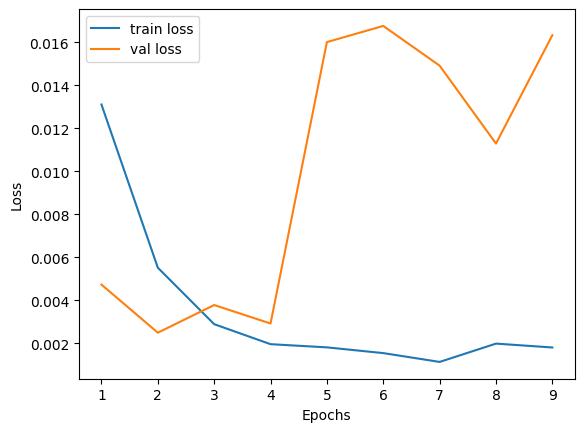

In [ ]:
import matplotlib.pyplot as plt 

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, label='train loss')
plt.plot(epochs, val_loss_values, label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

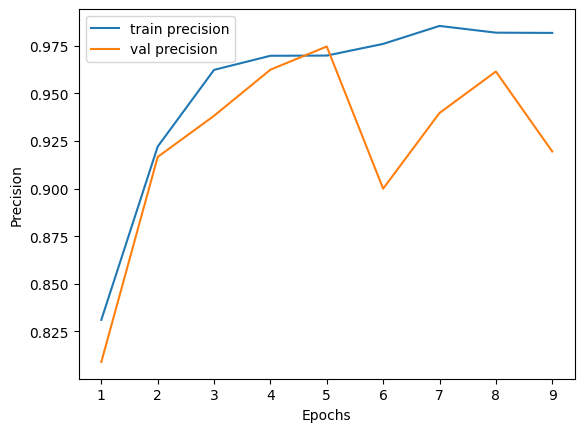

In [ ]:
precision_values = history_dict['precision']
val_precision_values = history_dict['val_precision']
epochs = range(1, len(precision_values) + 1)
plt.plot(epochs, precision_values, label='train precision')
plt.plot(epochs, val_precision_values, label='val precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

## Evaluate the model

In [ ]:
model.evaluate(x=(X_cat_email_val, X_cat_address_val, X_con_val), y=y_val)

595/595 [==============================] - 5s 9ms/step - loss: 0.0163 - accuracy: 0.9992 - precision: 0.9195 - recall: 0.9091


[0.016322558745741844,
 0.9992116689682007,
 0.9195402264595032,
 0.9090909361839294]

In [ ]:
from sklearn.metrics import precision_recall_curve

y_pred = model.predict((X_cat_email_val, X_cat_address_val, X_con_val))
precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred)

595/595 [==============================] - 5s 8ms/step


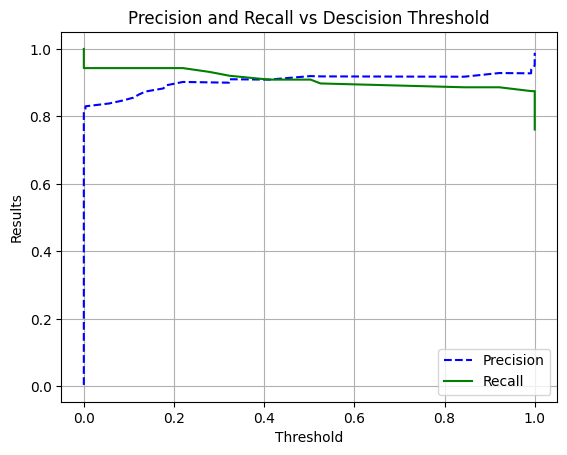

In [ ]:
import matplotlib.pyplot as plt 

plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

plt.xlabel('Threshold')
plt.ylabel('Results')
plt.title('Precision and Recall vs Descision Threshold')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import numpy as np

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

0.21977058

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred_90 = (y_pred >= threshold_90_precision) 
print(precision_score(y_val, y_pred_90), recall_score(y_val, y_pred_90), f1_score(y_val, y_pred_90))

0.9021739130434783 0.9431818181818182 0.9222222222222224


In [ ]:
from sklearn.metrics import precision_recall_curve

y_pred = model.predict((X_cat_email_test, X_cat_address_test, X_con_test))
y_pred_90 = (y_pred >= threshold_90_precision) 
print(precision_score(y_test, y_pred_90), recall_score(y_test, y_pred_90), f1_score(y_test, y_pred_90))

600/600 [==============================] - 5s 8ms/step
0.9327731092436975 0.9173553719008265 0.925


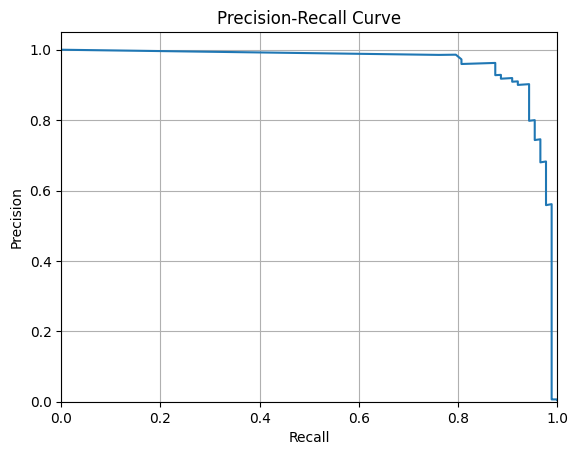

In [ ]:
plt.plot(recalls, precisions)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc_score(y_test, y_pred)

0.9948726951945606

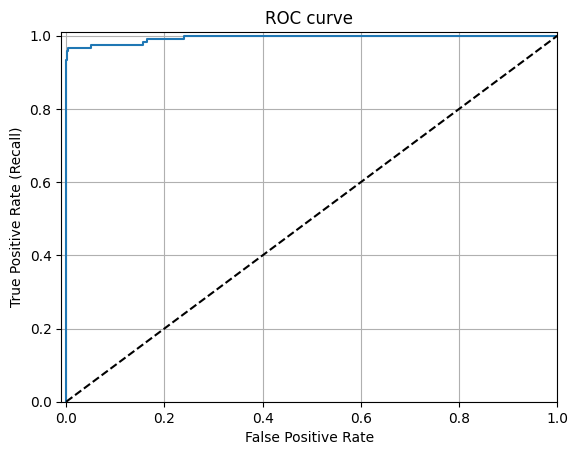

In [ ]:
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.ylim([0, 1.01])
plt.xlim([-0.01, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.title('ROC curve')
plt.show()

## Load the best model

In [ ]:
loaded_model = keras.models.load_model(checkpoint_path)
loaded_model.evaluate(x=(X_cat_email_val, X_cat_address_val, X_con_val), y=y_val)

595/595 [==============================] - 6s 9ms/step - loss: 0.0025 - accuracy: 0.9991 - precision: 0.9167 - recall: 0.8750


[0.002497008303180337, 0.9990540146827698, 0.9166666865348816, 0.875]

In [ ]:
from sklearn.metrics import precision_recall_curve

y_pred = loaded_model.predict((X_cat_email_val, X_cat_address_val, X_con_val))
precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred)

595/595 [==============================] - 5s 8ms/step


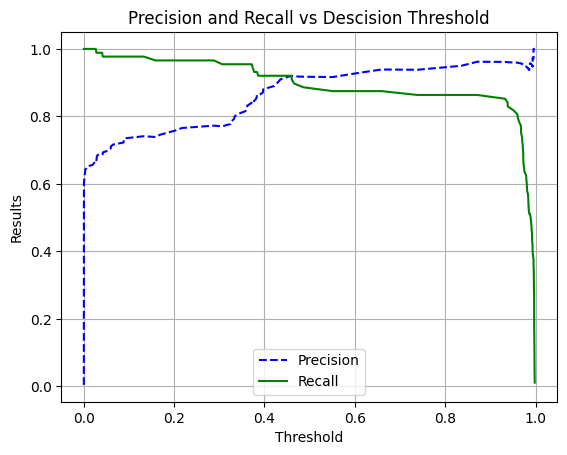

In [ ]:
import matplotlib.pyplot as plt 

plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

plt.xlabel('Threshold')
plt.ylabel('Results')
plt.title('Precision and Recall vs Descision Threshold')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import numpy as np

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # After several tests, 85% can yield the highest f1 score.
threshold_90_precision

0.42894652

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred_90 = (y_pred >= threshold_90_precision) 
print(precision_score(y_val, y_pred_90), recall_score(y_val, y_pred_90), f1_score(y_val, y_pred_90))

0.9 0.9204545454545454 0.9101123595505618


In [ ]:
from sklearn.metrics import precision_recall_curve

y_pred = loaded_model.predict((X_cat_email_test, X_cat_address_test, X_con_test))
y_pred_90 = (y_pred >= threshold_90_precision) 
print(precision_score(y_test, y_pred_90), recall_score(y_test, y_pred_90), f1_score(y_test, y_pred_90))

600/600 [==============================] - 5s 8ms/step
0.9487179487179487 0.9173553719008265 0.9327731092436975


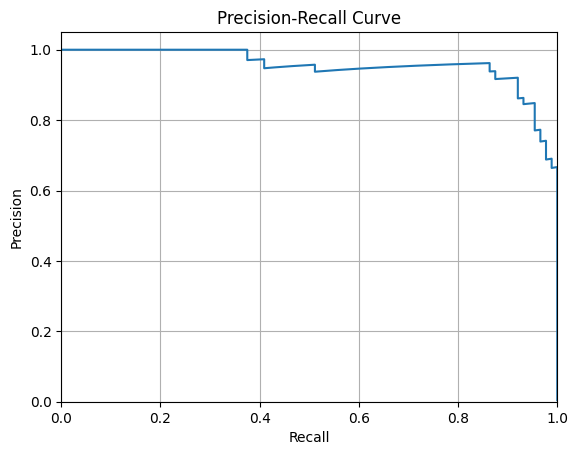

In [ ]:
plt.plot(recalls, precisions)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc_score(y_test, y_pred)

0.9997451086214407

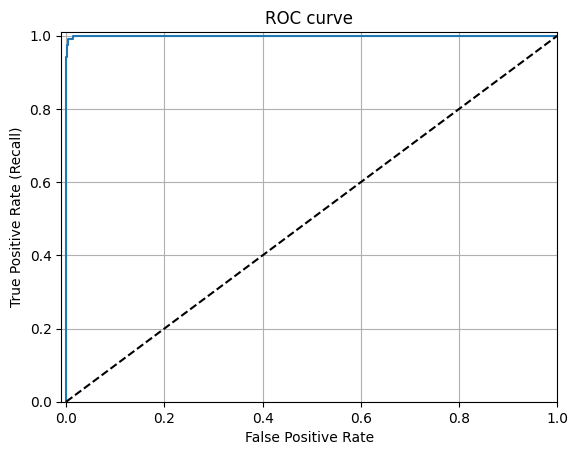

In [ ]:
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.ylim([0, 1.01])
plt.xlim([-0.01, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.title('ROC curve')
plt.show()

In [ ]:
import mlflow

# Log metrics
metrics = loaded_model.evaluate(x=(X_cat_email_val, X_cat_address_val, X_con_val), y=y_val)

mlflow.log_metric("val_loss", metrics[0])
mlflow.log_metric("val_accuracy", metrics[1])
mlflow.log_metric("val_precision", metrics[2])
mlflow.log_metric("val_recall", metrics[3])

# Log the model
mlflow.tensorflow.log_model(model, "keras_transformer_model")

595/595 [==============================] - 5s 8ms/step - loss: 0.0025 - accuracy: 0.9991 - precision: 0.9167 - recall: 0.8750


2023/06/03 07:28:03 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmp22ja9e10/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp22ja9e10/model/data/model/assets
